In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        self.initial_scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) +Z
        return self.out(Z)




In [2]:
X_low = np.array([-0.02])  # wealth lower bound
X_high = np.array([2])          # wealth upper bound


# neural network parameters
num_layers_FFNN = 4
num_layers_RNN = 0
nodes_per_layer = 50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'
# Training parameters
sampling_stages  = 6000   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 256
nSim_boundary = 1

dim_input = 1
dim_output = 2
 
model = DCGMNet(X_low, X_high,  
                 dim_input, dim_output, 
                 num_layers_FFNN, nodes_per_layer,
                 activation_FFNN)





In [3]:
# Aiyagari problem parameters
gamma = 2
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var

z1 = .1
z2 = .2
z = np.array([z1, z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1, la2])

eps = tf.constant(1e-10, dtype=tf.float32)


def u(c):
    return c**(1-gamma)/(1-gamma)


def u_deriv(c):
    return c**(-gamma)


def u_deriv_inv(c):
    return c**(-1/gamma)


In [4]:

def sampler(nSim_interior, nSim_boundary):
    ''' Sample space points from the function's domain
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at boundary to sample 
    ''' 
    
    # Sampler #1: domain interior    

    X_interior = tf.random.uniform(
        shape=[nSim_interior, 1], minval=X_low, maxval=X_high, dtype=tf.float32)


    a_alower = X_low[0] * tf.ones(shape = (nSim_boundary, 1), dtype=tf.float32)
    X_alower = a_alower

    return X_interior, X_alower

def control_c(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.gradients(V, a)[0]

    V_a = tf.maximum(1e-10 * tf.ones_like(V), V_a)

    c = u_deriv_inv(V_a)
    
    return c

def value_info(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    c = u_deriv_inv(V_a)
    
    s1 = z[0]*tf.ones_like(a)[:,0:1]+r*a[:,0:1]-c[:,0:1]
    s2 = z[1]*tf.ones_like(a)[:,0:1]+r*a[:,0:1]-c[:,1:2]
    s = tf.concat([s1[:,0:1],s2[:,0:1]],axis=1)

    return V, V_a, s



def loss_differentialoperator(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum(eps*tf.ones_like(V), V_a)


    c = u_deriv_inv(V_a)
    u_c = u(c) 
    
    diff_V_z1 = -rho * V[:, 0] + u_c[:, 0] + V_a[:, 0] * (z[0]+r*a[:, 0]-c[:, 0]) + la[0] * (V[:, 1] - V[:, 0])
    diff_V_z2 = -rho * V[:, 1] + u_c[:, 1] + V_a[:,1] * (z[1]+r*a[:,0]-c[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        
    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_differentialoperator_alower(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum( tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z+ r* a), V_a)

    c_new = u_deriv_inv(V_a_new)
    u_c_new = u(c_new) 
    

    diff_V_z1 = -rho * V[:,0] + u_c_new[:,0] + V_a[:,0]*(z[0]+r*a[:,0]-c_new[:,0]) + la[0]* (V[:,1] - V[:,0])
    diff_V_z2 = -rho * V[:,1] + u_c_new[:,1] + V_a[:,1]*(z[1]+r*a[:,0]-c_new[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        

    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_concave(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_aa = tf.concat([tf.gradients(V_a[:,0], a)[0],tf.gradients(V_a[:,1], a)[0]],axis=1)
    concave_V = tf.maximum(V_aa, tf.zeros_like(V))

    L = tf.reduce_mean( tf.square(concave_V ) )
    return L


def compute_loss(model, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    ''' 

    Loss_V_interior, L1 = loss_differentialoperator(model, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower(model, X_alower)
    
    L3 =  loss_concave(model, X_interior)

    L4 = tf.cast(0,tf.float32)

    L = L1 + L2 + L3 + L4
    
    return L
    
    
def get_grad(model, X_interior, X_alower):
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_interior, X_alower)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, grad


In [5]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=starting_learning_rate)


@tf.function
def train_step(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_interior, X_alower)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(nSim_interior, nSim_boundary)

    for _ in range(steps_per_sample):
        loss = train_step(X_interior, X_alower)
    
    hist.append(loss.numpy())
    
    if i%100==0:
        tf.print(i,loss)
    

0 64.873642
100 6.06147385
200 0.227594405
300 0.058244735
400 0.0042186887
500 0.000879067346
600 0.000561071211
700 0.000132970279
800 0.000149558764
900 6.29567949e-05
1000 7.67098827e-05
1100 4.51727283e-05
1200 2.67054638e-05
1300 9.21162427e-06
1400 1.05933714e-05
1500 2.26951397e-06
1600 2.64542359e-06
1700 2.49645291e-06
1800 1.80915213e-05
1900 2.32788261e-06
2000 4.53117536e-06
2100 1.70368219e-06
2200 3.94922608e-06
2300 1.1078374e-05
2400 8.15802832e-06
2500 2.76830292e-07
2600 4.85773626e-07
2700 1.77266793e-06
2800 4.96803636e-07
2900 1.62334231e-06
3000 4.05473611e-06
3100 2.76221101e-07
3200 4.85033411e-07
3300 3.65300621e-05
3400 5.42633245e-07
3500 7.3259e-07
3600 8.93901142e-06
3700 3.90941693e-07
3800 5.31172191e-06
3900 1.53708443e-05
4000 6.65149782e-05
4100 1.73504657e-06
4200 4.62821663e-06
4300 4.7958315e-07
4400 5.3883291e-06
4500 2.627485e-07
4600 2.25345218e-07
4700 1.06097275e-07
4800 4.27180737e-07
4900 4.2611515e-07
5000 1.13589948e-07
5100 9.35744447e-06

Text(0.5, 1.0, 'Saving')

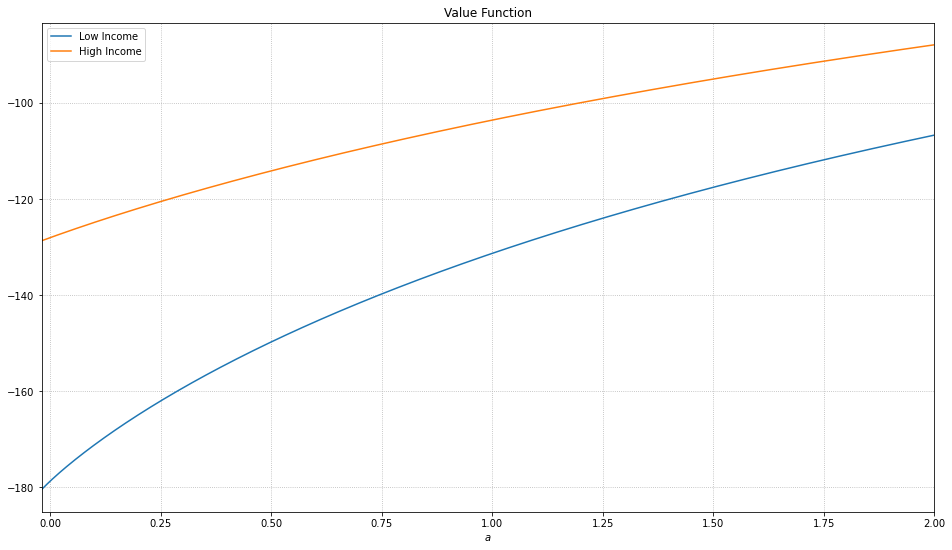

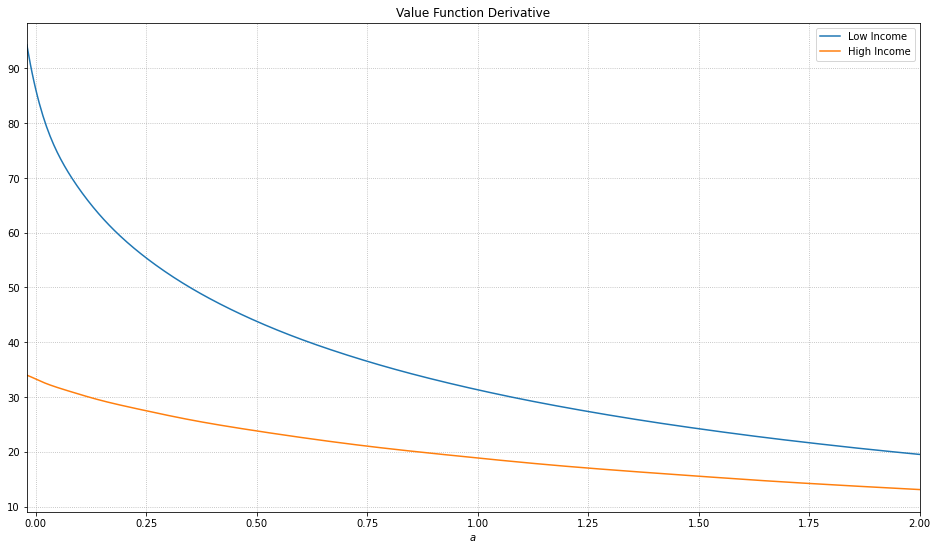

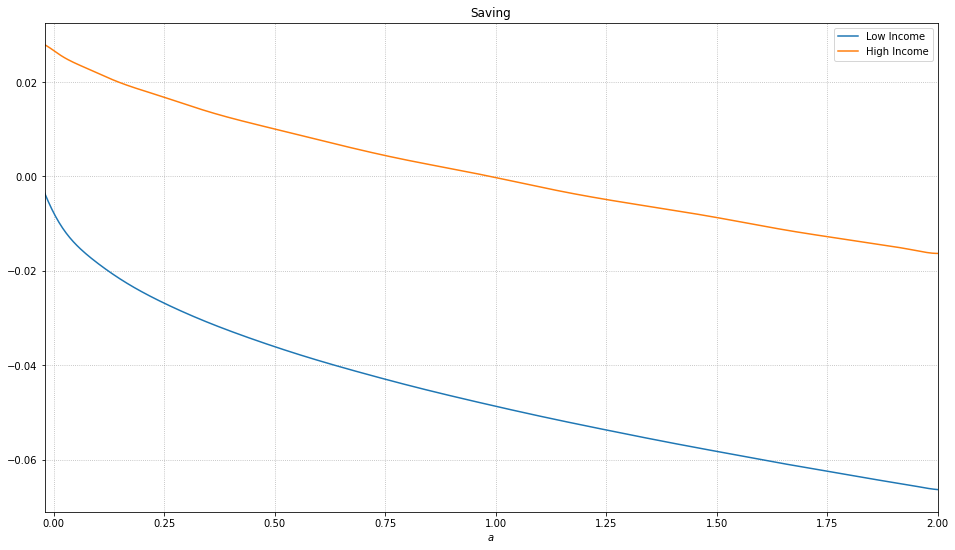

In [6]:
aspace = np.linspace(-0.02, 2, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A==-0.02].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:,0:1]
    tape.watch(a)
    V = model(tf.stack([a[:, 0]], axis=1))
    Va_1 = tape.gradient(V[:,0], a)
    Va_2 = tape.gradient(V[:, 1], a)
    Va = tf.concat([Va_1,Va_2],axis=1)

fitted_V = V.numpy().reshape(500, 2)
fitted_Va = Va.numpy().reshape(500,2)
fitted_saving = z+r*X_interior - u_deriv_inv(fitted_Va)

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_V[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_V[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_Va[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_Va[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function Derivative")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_saving[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_saving[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low,X_high)
plt.title("Saving")


In [53]:

def loss_differentialoperator_KFE(model, model_g, X):
    a = X[:, 0:1]

    V = model(tf.stack([a[:, 0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:, 0], a)[0],
                    tf.gradients(V[:, 1], a)[0]], axis=1)
    c = u_deriv_inv(V_a)

    s = z+r*a - c
    g = model_g(tf.stack([a[:, 0]], axis=1))
        
    g_a = tf.concat([tf.gradients(g[:, 0], a)[0],
                      tf.gradients(g[:, 1], a)[0]], axis=1)


    diff_g_z1 = -(g_a[:, 0]*s[:,0]+r*g[:,0]) - la[0] * g[:, 0] + la[1] * g[:, 1]
    diff_g_z2 = -(g_a[:, 1]*s[:,1]+r*g[:,1]) - la[1] * g[:, 1] + la[0] * g[:, 0]


    diff_g = tf.concat([diff_g_z1, diff_g_z2, diff_g_z1 + diff_g_z2], axis=0)

    L = tf.reduce_mean(tf.square(diff_g))
    return diff_g, L


def loss_differentialoperator_alower_KFE(model, model_g, X):
    a = X[:, 0:1]

    V = model(tf.stack([a[:, 0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:, 0], a)[0],
                    tf.gradients(V[:, 1], a)[0]], axis=1)
    V_a = tf.math.maximum(tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z + r * a), V_a)

    c_new = u_deriv_inv(V_a_new)

    s = z+r*a - c_new
    g = model_g(tf.stack([a[:, 0]], axis=1))
    
    g_a = tf.concat([tf.gradients(g[:, 0], a)[0],
                      tf.gradients(g[:, 1], a)[0]], axis=1)


    diff_g_z1 = -(g_a[:, 0]*s[:,0]+r*g[:,0])*tf.cast(s[:,0]>0,tf.float32)  - la[0] * g[:, 0] + la[1] * g[:, 1]
    diff_g_z2 = -(g_a[:, 1]*s[:,1]+r*g[:,1])*tf.cast(s[:,1]>0,tf.float32) - la[1] * g[:, 1] + la[0] * g[:, 0]

    diff_g = tf.concat([diff_g_z1, diff_g_z2, diff_g_z1 + diff_g_z2], axis=0)

    L = tf.reduce_mean(tf.square(diff_g))
    return diff_g, L


def loss_density_KFE(model, model_g, X):
    a = X[:, 0:1]

    g = model_g(tf.stack([a[:, 0]], axis=1))

    g_sum = (X_high-X_low) * \
        tf.reduce_mean(g[:, 0]) + (X_high-X_low) * tf.reduce_mean(g[:, 1]) - 1
    # g_sum = (X_high-X_low) * \
    #     tf.reduce_mean(g[:, 0]) - 1

    g_positive = tf.minimum(g, tf.zeros_like(g))

    # L = tf.reduce_mean(tf.square(g_sum)) + tf.reduce_mean(tf.square(g_positive))
    L = tf.reduce_mean(tf.square(g_positive))
    
    return L


def loss_void_space(model_g, X):
    
    X = X_high[0] * tf.ones(shape=(nSim_boundary, 1), dtype=tf.float32)
    g = model_g(tf.stack([X[:, 0]], axis=1))

    L = tf.reduce_mean(tf.square(g))
    return L


def compute_loss_KFE(model, model_g, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    '''

    Loss_V_interior, L1 = loss_differentialoperator_KFE(
        model, model_g, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower_KFE(
        model, model_g, X_alower)

    L3 = loss_density_KFE(model, model_g, X_interior)

    L4 = loss_void_space(model_g, X_interior)


    L = L1 + L2 + L3 +L4
    # L = L1 + L3 +L4
    # L = L1 +L3

    return L


def get_grad_KFE(model, model_g, X_interior, X_alower):

    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model_g.trainable_variables)
        loss = compute_loss_KFE(model, model_g, X_interior, X_alower)

    grad = tape.gradient(loss, model_g.trainable_variables)
    del tape

    return loss, grad


model_g = DCGMNet(X_low, X_high,
                dim_input, dim_output,
                num_layers_FFNN, nodes_per_layer,
                activation_FFNN)


In [54]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)


@tf.function
def train_step_KFE(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad_KFE(model, model_g, X_interior, X_alower)

    # Perform gradient descent step
    optimizer2.apply_gradients(zip(grad_theta, model_g.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(nSim_interior, nSim_boundary)

    for _ in range(steps_per_sample):
        loss = train_step_KFE(X_interior, X_alower)

    hist.append(loss.numpy())

    if i % 100 == 0:
        tf.print(i, loss)


0 0.104623035
100 2.08716028e-06
200 8.94362188e-07
300 1.14349223e-06
400 6.25250914e-06
500 9.3206404e-07
600 7.61376782e-07
700 2.90391199e-06
800 3.29752766e-06
900 4.43823325e-07
1000 9.82006782e-07
1100 6.99102543e-07
1200 2.90722869e-06
1300 6.75832098e-06
1400 3.44021714e-07
1500 5.92881634e-07
1600 1.49276843e-06
1700 5.85132038e-05
1800 3.1090724e-07
1900 4.19939596e-07
2000 8.79067e-06
2100 1.54270737e-07
2200 1.19064634e-06
2300 6.91617925e-06
2400 1.72453369e-07
2500 4.82371263e-07
2600 1.11809605e-07
2700 4.89560477e-07
2800 9.59895333e-05
2900 1.22357662e-07
3000 1.64128721e-06
3100 2.66379629e-07
3200 1.44267669e-05
3300 1.21014e-07
3400 2.68393933e-07
3500 1.10970419e-07
3600 4.37182521e-08
3700 2.17848907e-07
3800 5.33870477e-08
3900 9.65020703e-08
4000 6.52894187e-07
4100 1.41764403e-07
4200 9.16944373e-06
4300 3.63380259e-08
4400 1.19342545e-07
4500 2.44696619e-08
4600 4.22364792e-08
4700 1.36211298e-07
4800 7.66650601e-08
4900 2.6917467e-05
5000 1.03379776e-07
5100

Text(0.5, 1.0, 'Density')

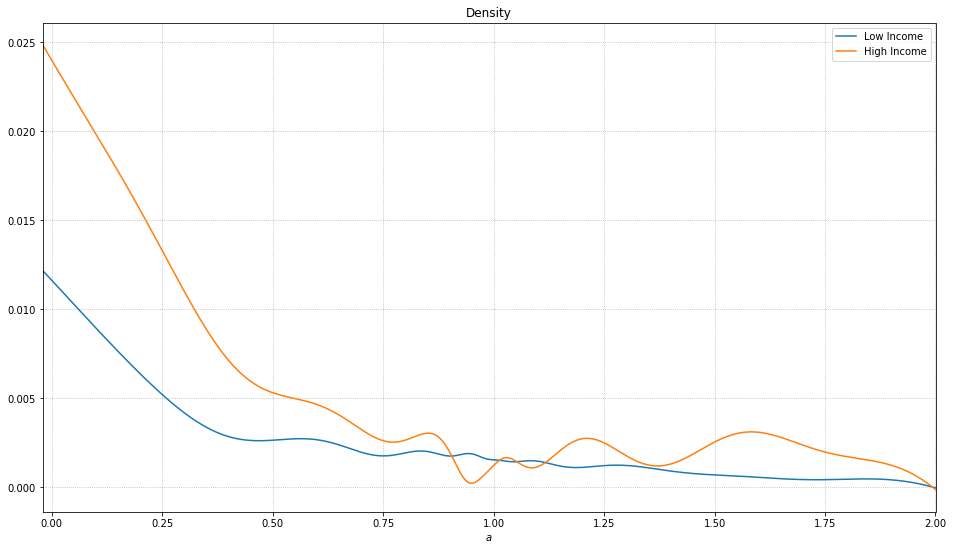

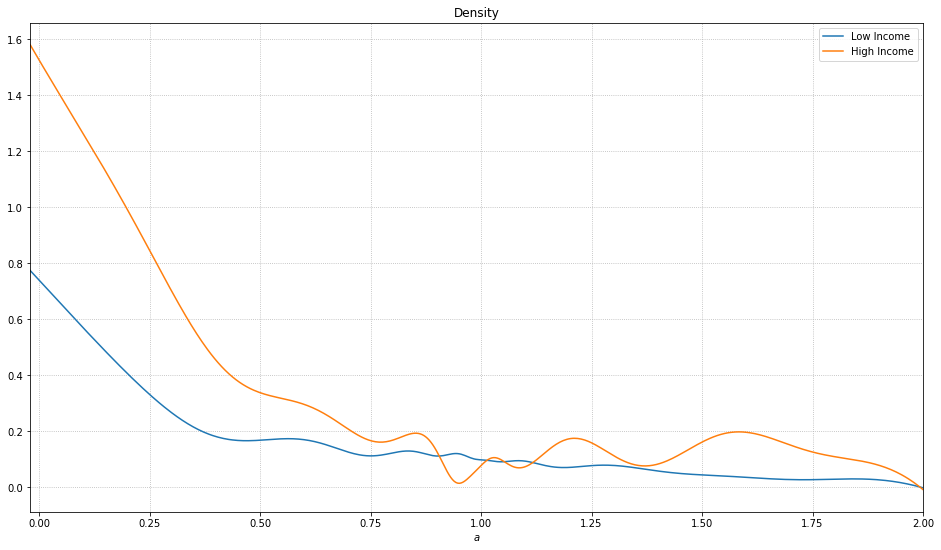

In [56]:

aspace = np.linspace(-0.02, 2, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A == -0.02].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:, 0:1]
    tape.watch(a)
    g = model_g(tf.stack([a[:, 0]], axis=1))
    
del tape

fitted_g = g.numpy().reshape(500, 2)


fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_g[:, 0], label="Low Income")
plt.plot(X_interior[:, 0], fitted_g[:, 1], label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Density")

g_sum = (X_high-X_low) * \
    np.mean(fitted_g[:, 0]) + (X_high-X_low) * np.mean(fitted_g[:, 1]) 

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_g[:, 0]/g_sum, label="Low Income")
plt.plot(X_interior[:, 0], fitted_g[:, 1]/g_sum, label="High Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Density")

Text(0.5, 1.0, 'Density')

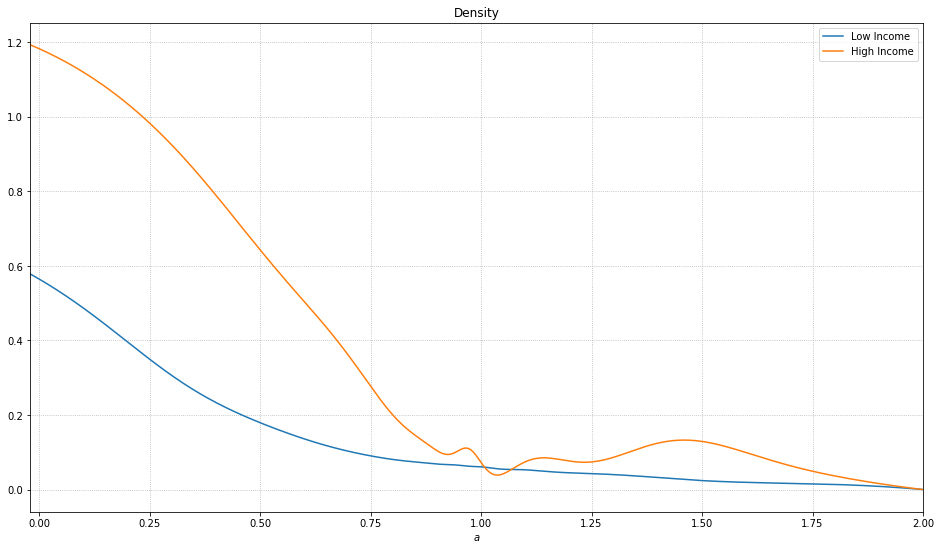

In [17]:
g_sum

array([-0.89951357])